## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import constants
import seaborn as sns
import exoplanet as xo
import astropy.units as u
from astropy.timeseries import LombScargle as ls
import lightkurve as lk
from astropy.io import fits


from uncertainties import ufloat
from uncertainties.umath import *
from scipy import constants as c
from scipy import stats

import pymc as pm
import pymc_ext as pmx
import arviz as az
from celerite2.pymc import GaussianProcess, terms
import pytensor.tensor as pt
%matplotlib inline

## System parameters

In [2]:
# from exoplanet.eu catalog: https://exoplanet.eu/catalog/lp_714_47_b--7534/#publication_21546
# Dreizler et al 2020: https://www.aanda.org/articles/aa/full_html/2020/12/aa38016-20/aa38016-20.html
# exofop: https://exofop.ipac.caltech.edu/tess/target.php?id=70899085
TIC_ID = 70899085

epoch_tess = ufloat(2459196.115341, 0.0005086)
period_tess = ufloat(4.0520368, 0.0000044)
duration_tess = 1.5605127851947
strad_tess = ufloat(0.607, 0.018)
stmass_tess = ufloat(0.594, 0.020)
stteff_tess = ufloat(3779, 157)

mass_pub = ufloat(0.0969, 0.0047)*u.M_jup.to(u.M_earth)
period_pub = ufloat(4.052037, 4e-06) # days
e_pub = ufloat(0.04, 0.02)
K_pub = ufloat(17.6, 0.8) # m/s
epoch_pub = ufloat(0.38421+58438, 0.00025)
radius_pub = ufloat(4.7, 0.3) # R_earth

stteff_pub = ufloat(3950, 51)
strad_pub = ufloat(0.584, 0.016)
stmass_pub = ufloat(0.59, 0.02)

## Read RVs

### Model variables

### Model version

In [69]:
# versiones
# 0: GP in LC, per instrument offset en RVs
# 1: GP in LC, per instrument offset + quadratic drift en RVs
# 2: GP in LC, noise GP in RVs
# 3: GP in LC, noise GP in RVs + drift
version_names = ['offset', 'drift', 'GP', 'GP+drift']

n_planets = 2

version = 0

### Model build

In [70]:
# time vectors for plotting
t_rv = np.linspace(0, 100, 1500)

def build_model(version=0, map=True):
    with pm.Model() as model:
        # Parameters for the stellar properties
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from TESS
        mstar = pm.math.constant(0.3)
        rstar = pm.math.constant(0.3)
            

        # # Orbital parameters for the planet

        t0 = pm.math.constant(0)

        P = pm.math.constant(10)
        K = pm.math.constant(10)
            
        # Fit in terms of ror
        ror = pm.math.constant(0.07)
        r_pl = pm.Deterministic("r_pl", ror * rstar)
        b = pm.math.constant(0.74)  
    
        h, k = xo.unit_disk("h", "k", initval=np.array([0.01, 0.01]))
        ecc = pm.math.constant(0.01)
        omega = pm.math.constant(0)

        # derived parameters
        m_pl = pm.Deterministic('m_pl', K*pt.sqrt(1-ecc**2)*(P*u.day.to(u.second)*(mstar*u.M_sun.to(u.kg))**2/(2*np.pi*constants.G))**(1/3)*u.kg.to(u.M_earth))
        density_pl = pm.Deterministic('density_pl', m_pl*u.M_earth.to(u.g)/(4/3*np.pi*(r_pl*u.R_sun.to(u.cm))**3))    
        a = pm.Deterministic('a', ((P*u.day.to(u.second))**2*constants.G*(mstar*u.M_sun.to(u.kg)+m_pl*u.M_earth.to(u.kg))/(4*np.pi**2))**(1/3)*u.m.to(u.au))
        teq = pm.Deterministic('teq', stteff_pub.n*(rstar*u.R_sun.to(u.au)/a)**(1/2)*(1/4)**(1/4))
    
        orbit = xo.orbits.KeplerianOrbit(
            r_star=rstar,
            m_star=mstar,
            period=P,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
            )
    
        if n_planets == 2:
            t0_2 = pm.math.constant(5)
            P_2 = pm.math.constant(10)
            K_2 = pm.math.constant(10)
            orbit_2 = xo.orbits.KeplerianOrbit(
                r_star=rstar,
                m_star=mstar,
                period=P_2,
                t0=t0_2,
                )
        if version == 1 or version == 3:
            trend = pm.Normal("trend", mu=0, sigma=np.array([0.01, 0.1]), shape=2)
        # Function to compute the radial velocity model
        def get_rv_model(x, name=""):
            vrad = orbit.get_radial_velocity(x, K=K)
            if n_planets == 2:
                vrad_2 = orbit_2.get_radial_velocity(x, K=K_2)

            if version == 1 or version == 3:
                # Define the background model
                # Use only the first two columns (we removed the constant term)
                A = np.vander(x - 50, 3)[:,0:2]
                bkg = pm.Deterministic("bkg" + name, pt.dot(A, trend))
                if n_planets == 2:
                    pm.Deterministic("vrad" + name, vrad + vrad_2)
                    return pm.Deterministic("rv_model" + name, vrad + vrad_2 + bkg)
                else:
                    pm.Deterministic("vrad" + name, vrad)
                    return pm.Deterministic("rv_model" + name, vrad + bkg)
            elif version == 0 or version == 2:
                if n_planets == 2:
                    pm.Deterministic("vrad" + name, vrad + vrad_2)
                    return pm.Deterministic("rv_model" + name, vrad + vrad_2)
                else:
                    pm.Deterministic("vrad" + name, vrad)
                    return pm.Deterministic("rv_model" + name, vrad)
        
        get_rv_model(t_rv, "_pred")
        
        if map:
            # Find MAP
            map_params = pm.find_MAP()
            map_soln = pmx.optimize(start=map_params)
        else:
            map_soln = None
    return model, map_soln

model, map_soln = build_model(version=version, map=True)

Output()

Output()

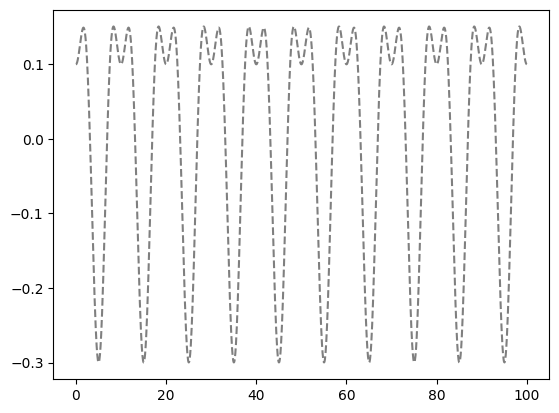

In [71]:
with model:
    # evaluate and plot the model
    t_lc = np.linspace(0, 100, 1000)
    t_rv = np.linspace(0, 100, 1500
    )   
    plt.plot(t_rv, map_soln['vrad_pred'], "--k", alpha=0.5)
    #plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    #plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")
    